In [34]:
!pip install -q kaggle

In [35]:
from google.colab import files
files.upload()   # upload kaggle.json

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"payaldhokane","key":"87a6da0fac302f26468977f0dc75158b"}'}

In [36]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [37]:
!kaggle competitions download -c store-sales-time-series-forecasting

store-sales-time-series-forecasting.zip: Skipping, found more recently modified local copy (use --force to force download)


In [38]:
!unzip store-sales-time-series-forecasting.zip -d store_sales

Archive:  store-sales-time-series-forecasting.zip
replace store_sales/holidays_events.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

#Loading of data

In [39]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [40]:
import pandas as pd

PATH = "/content/store_sales/"

train = pd.read_csv(PATH + "train.csv")
test = pd.read_csv(PATH + "test.csv")
oil = pd.read_csv(PATH + "oil.csv")
stores = pd.read_csv(PATH + "stores.csv")
transactions = pd.read_csv(PATH + "transactions.csv")
holidays = pd.read_csv(PATH + "holidays_events.csv")
sample_submission = pd.read_csv(PATH + "sample_submission.csv")

In [41]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


#STEP 1: Exploratory Data Analysis (EDA)

In [42]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [43]:
train['sales'].describe()

,sales
count,3.000888e+06
mean,3.577757e+02
std,1.101998e+03
min,0.000000e+00
25%,0.000000e+00
50%,1.100000e+01
75%,1.958473e+02
max,1.247170e+05


In [44]:
train.isnull().sum()

,0
id,0
date,0
store_nbr,0
family,0
sales,0
onpromotion,0


In [45]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

**1.Overall Sales Trend**

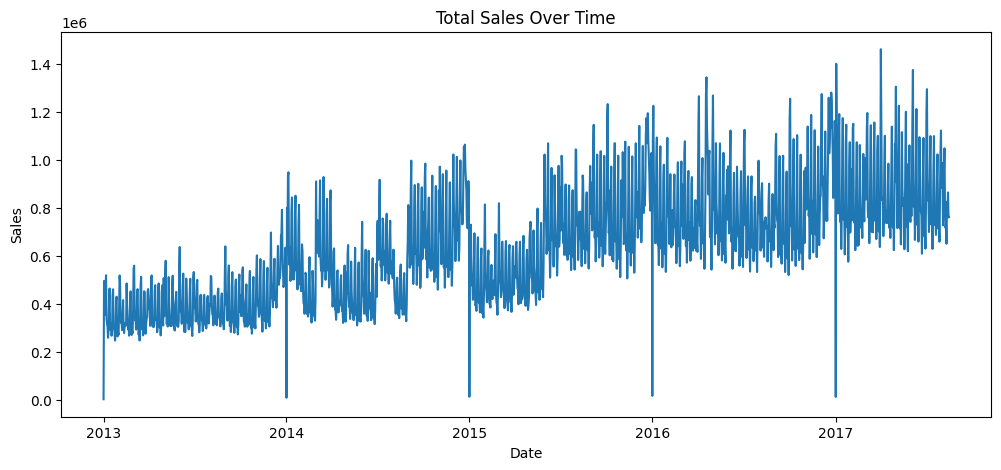

In [46]:
daily_sales = train.groupby('date')['sales'].sum()

plt.figure(figsize=(12,5))
plt.plot(daily_sales)
plt.title("Total Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

**Insight**

*  Strong seasonality
*  Trend changes over years
*  Sales drop during special events (earthquake, holidays)

**2.Sales by Product Family**

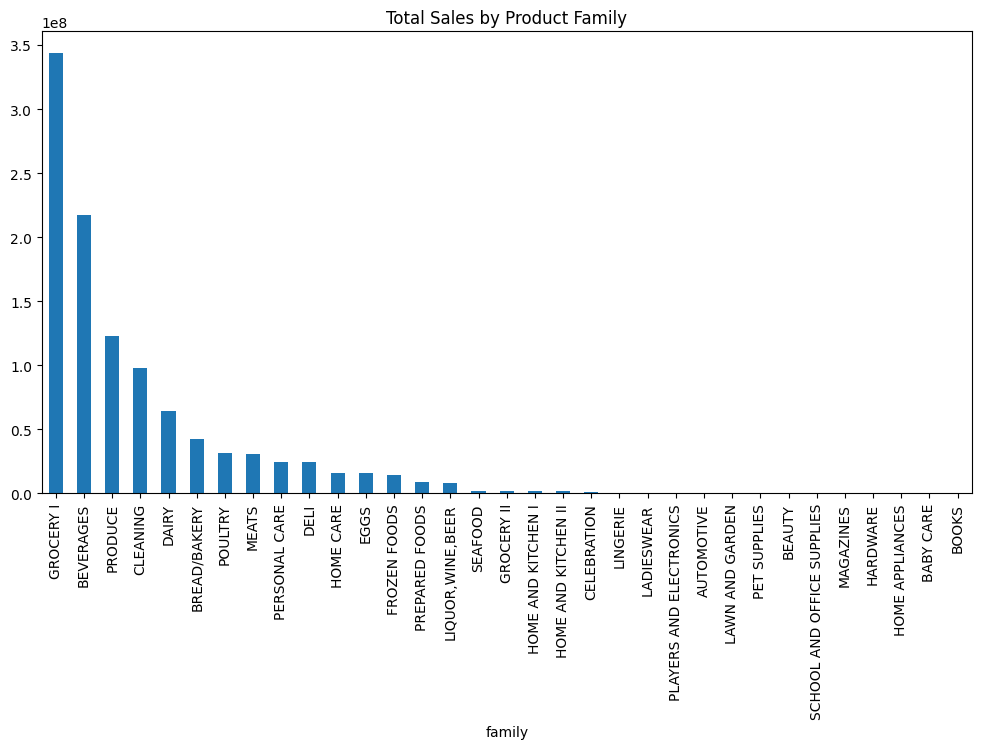

In [47]:
family_sales = train.groupby('family')['sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(12,6))
family_sales.plot(kind='bar')
plt.title("Total Sales by Product Family")
plt.show()

**Insight**

* Some families dominate sales
* Important for feature engineering

**3.Promotion Impact**

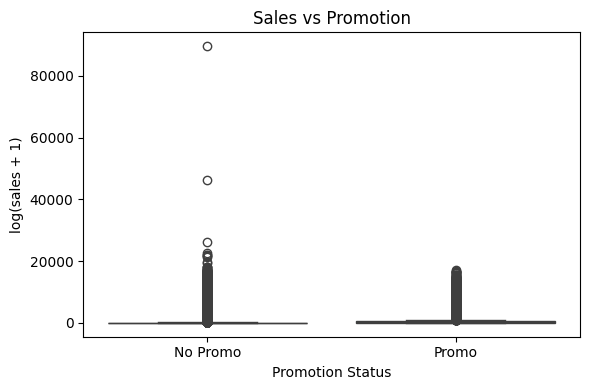

In [50]:
train['promo_flag'] = train['onpromotion'].map({0: 'No Promo', 1: 'Promo'})

plt.figure(figsize=(6,4))
sns.boxplot(x='promo_flag', y='sales', data=train)

plt.title("Sales vs Promotion")
plt.xlabel("Promotion Status")
plt.ylabel("log(sales + 1)")
plt.tight_layout()
plt.show()

Insight

* Promotions significantly increase sales

**4.Store Type Impact**

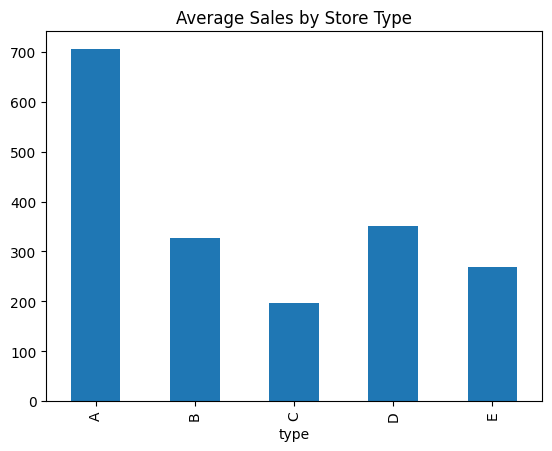

In [51]:
store_sales = train.merge(stores, on='store_nbr')
store_type_sales = store_sales.groupby('type')['sales'].mean()

store_type_sales.plot(kind='bar', title="Average Sales by Store Type")
plt.show()

**Overview**
* Sales show strong seasonality
* Promotions significantly increase sales
* Different store types behave differently
* Multiple time series exist

#STEP 2: Feature Engineering (Core of the Model)

**2.1 Create Date-Based Features**

In [52]:
def add_date_features(df):
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int)
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    return df

train = add_date_features(train)
test = add_date_features(test)

**2.2 Merge Store Information**

In [53]:
train = train.merge(stores, on='store_nbr', how='left')
test = test.merge(stores, on='store_nbr', how='left')

**2.3 Merge Transactions Data**

In [54]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [55]:
transactions['date'] = pd.to_datetime(transactions['date'])
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [56]:
train = train.merge(
    transactions,
    how='left',
    left_on=['date', 'store_nbr'],
    right_on=['date', 'store_nbr']
)

test = test.merge(
    transactions,
    how='left',
    left_on=['date', 'store_nbr'],
    right_on=['date', 'store_nbr']
)

In [57]:
train['transactions'] = train['transactions'].fillna(0)
test['transactions'] = test['transactions'].fillna(0)

In [58]:
train[['date', 'store_nbr', 'transactions']].head()

,date,store_nbr,transactions
0,2013-01-01,1,0.0
1,2013-01-01,1,0.0
2,2013-01-01,1,0.0
3,2013-01-01,1,0.0
4,2013-01-01,1,0.0


**2.4 Merge Oil Prices**

In [63]:

oil = oil.sort_values('date')
oil['dcoilwtico'] = oil['dcoilwtico'].ffill()

train = train.merge(oil[['date','dcoilwtico']], on='date', how='left')
test = test.merge(oil[['date','dcoilwtico']], on='date', how='left')

train['dcoilwtico'] = train['dcoilwtico'].fillna(method='ffill')
test['dcoilwtico'] = test['dcoilwtico'].fillna(method='ffill')

print("✅ Oil merge done")

✅ Oil merge done


/tmp/ipython-input-3261696195.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train['dcoilwtico'] = train['dcoilwtico'].fillna(method='ffill')
/tmp/ipython-input-3261696195.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test['dcoilwtico'] = test['dcoilwtico'].fillna(method='ffill')


**2.5 Merge Holidays**

In [64]:

holidays_simple = holidays[['date']].drop_duplicates()
holidays_simple['is_holiday'] = 1


train = train.merge(holidays_simple, on='date', how='left')
test = test.merge(holidays_simple, on='date', how='left')


train['is_holiday'] = train['is_holiday'].fillna(0).astype(int)
test['is_holiday'] = test['is_holiday'].fillna(0).astype(int)

print("✅ Holidays merge done")


✅ Holidays merge done


**2.6 Create Lag Features**

In [65]:
train = train.sort_values(['store_nbr', 'family', 'date'])

for lag in [7, 14, 28]:
    train[f'lag_{lag}'] = (
        train.groupby(['store_nbr', 'family'])['sales']
        .shift(lag)
    )

In [66]:
train.fillna(0, inplace=True)

**2.7 Target Transformation (RMSLE)**

In [67]:
train['log_sales'] = np.log1p(train['sales'])

In [68]:
train.head()


,id,date,store_nbr,family,sales,onpromotion,promo_flag,year,month,day,dayofweek,weekofyear,is_weekend,city,state,type_x,cluster,transactions_x,transactions_y,type_y,lag_7,lag_14,lag_28,dcoilwtico,is_holiday,log_sales
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,No Promo,2013,1,1,1,1,0,Quito,Pichincha,D,13,0.0,0.0,Holiday,0.0,0.0,0.0,0.00,1,0.000000
1,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,No Promo,2013,1,2,2,1,0,Quito,Pichincha,D,13,2111.0,2111.0,0,0.0,0.0,0.0,93.14,0,1.098612
2,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,No Promo,2013,1,3,3,1,0,Quito,Pichincha,D,13,1833.0,1833.0,0,0.0,0.0,0.0,92.97,0,1.386294
3,5346,2013-01-04,1,AUTOMOTIVE,3.0,0,No Promo,2013,1,4,4,1,0,Quito,Pichincha,D,13,1863.0,1863.0,0,0.0,0.0,0.0,93.12,0,1.386294
4,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,No Promo,2013,1,5,5,1,1,Quito,Pichincha,D,13,1509.0,1509.0,Work Day,0.0,0.0,0.0,93.12,1,1.791759


**Clean up**

In [69]:
# Keep only necessary columns
cols_to_keep = [
    'date', 'store_nbr', 'family', 'sales', 'log_sales', 'onpromotion',
    'promo_flag', 'year', 'month', 'day', 'dayofweek', 'weekofyear', 'is_weekend',
    'city', 'state', 'type_x', 'cluster', 'transactions_x',
    'lag_7', 'lag_14', 'lag_28', 'dcoilwtico', 'is_holiday'
]

train = train[cols_to_keep]

# Rename for clarity
train.rename(columns={'type_x':'store_type', 'transactions_x':'transactions'}, inplace=True)

In [70]:
train.head()
train.isnull().sum()

,0
date,0
store_nbr,0
family,0
sales,0
log_sales,0
onpromotion,0
promo_flag,0
year,0
month,0
day,0


#Baseline Model

In [72]:
# 1. Inspect columns
print(train.columns)

# 2. Rename duplicates safely
if 'store_nbr_x' in train.columns:
    train.rename(columns={'store_nbr_x':'store_nbr'}, inplace=True)
if 'store_nbr_y' in train.columns:
    train.drop(columns=['store_nbr_y'], inplace=True, errors='ignore')

if 'transactions_x' in train.columns:
    train.rename(columns={'transactions_x':'transactions'}, inplace=True)
if 'transactions_y' in train.columns:
    train.drop(columns=['transactions_y'], inplace=True, errors='ignore')

if 'type_x' in train.columns:
    train.rename(columns={'type_x':'store_type'}, inplace=True)
if 'type_y' in train.columns:
    train.drop(columns=['type_y'], inplace=True, errors='ignore')

# 3. Verify final column names
print(train.columns)

Index(['date', 'store_nbr', 'family', 'sales', 'log_sales', 'onpromotion',
       'promo_flag', 'year', 'month', 'day', 'dayofweek', 'weekofyear',
       'is_weekend', 'city', 'state', 'store_type', 'cluster', 'transactions',
       'lag_7', 'lag_14', 'lag_28', 'dcoilwtico', 'is_holiday'],
      dtype='object')
Index(['date', 'store_nbr', 'family', 'sales', 'log_sales', 'onpromotion',
       'promo_flag', 'year', 'month', 'day', 'dayofweek', 'weekofyear',
       'is_weekend', 'city', 'state', 'store_type', 'cluster', 'transactions',
       'lag_7', 'lag_14', 'lag_28', 'dcoilwtico', 'is_holiday'],
      dtype='object')


In [74]:
from sklearn.metrics import mean_squared_log_error
import numpy as np


cutoff_date = train['date'].max() - pd.Timedelta(days=28)
train_set = train[train['date'] <= cutoff_date].copy()
val_set = train[train['date'] > cutoff_date].copy()


lag_7_mean = train_set.groupby(['store_nbr', 'family'])['lag_7'].mean().reset_index()
lag_7_mean.rename(columns={'lag_7':'sales_pred'}, inplace=True)


val_set = val_set.merge(lag_7_mean, on=['store_nbr','family'], how='left')
val_set['sales_pred'] = val_set['sales_pred'].fillna(0)


rmsle = np.sqrt(mean_squared_log_error(val_set['sales'], val_set['sales_pred']))
print("Baseline RMSLE:", round(rmsle, 5))

Baseline RMSLE: 0.69581


#LIGHTBGM MODEL

In [77]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_log_error
import numpy as np


features = [
    'onpromotion', 'lag_7','lag_14','lag_28','transactions','dcoilwtico','is_holiday',
    'year','month','day','dayofweek','weekofyear','is_weekend'
]
target = 'log_sales'

# Time-based split
cutoff_date = train['date'].max() - pd.Timedelta(days=28)
X_train = train[train['date'] <= cutoff_date][features]
y_train = train[train['date'] <= cutoff_date][target]
X_val = train[train['date'] > cutoff_date][features]
y_val = train[train['date'] > cutoff_date][target]


model = lgb.LGBMRegressor(
    objective='regression',
    learning_rate=0.1,
    num_leaves=31,
    n_estimators=500,  # fixed number
    random_state=42
)


model.fit(X_train, y_train)


y_pred_log = model.predict(X_val)
y_pred = np.expm1(y_pred_log)  # inverse log transform


rmsle = np.sqrt(mean_squared_log_error(np.expm1(y_val), y_pred))
print("LightGBM RMSLE:", round(rmsle,5))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.229104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1589
[LightGBM] [Info] Number of data points in the train set: 2974158, number of used features: 13
[LightGBM] [Info] Start training from score 2.917290
LightGBM RMSLE: 0.43403


#FEATURE ENGINEERING: Rolling & Month Lag Features

In [79]:
# Ensure train sorted
train = train.sort_values(['store_nbr','family','date']).copy()

# Rolling mean features (train only)
for window in [7,14,28]:
    train[f'roll_mean_{window}'] = (
        train.groupby(['store_nbr','family'])['sales']
        .transform(lambda x: x.shift(1).rolling(window).mean())
    )

# Month-lag features (train only)
for lag in [28,56]:
    train[f'month_lag_{lag}'] = (
        train.groupby(['store_nbr','family'])['sales']
        .shift(lag)
    )

# Fill NaNs in train
train.fillna(0, inplace=True)

print("✅ Rolling + month lag features added to train")
train[['roll_mean_7','roll_mean_14','roll_mean_28','month_lag_28','month_lag_56']].head()

✅ Rolling + month lag features added to train


,roll_mean_7,roll_mean_14,roll_mean_28,month_lag_28,month_lag_56
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0


In [81]:
# -----------------------------
# 1. Create a helper for last known lag values per store & family
# -----------------------------
last_sales = train.groupby(['store_nbr','family']).tail(56)  # max lag used

# Initialize lag columns in test with 0
for col in ['lag_7','lag_14','lag_28','roll_mean_7','roll_mean_14','roll_mean_28','month_lag_28','month_lag_56']:
    test[col] = 0

# -----------------------------
# 2. Fill test lag features using last available train sales
# -----------------------------
for (store, family), group in last_sales.groupby(['store_nbr','family']):
    idx = test[(test['store_nbr']==store) & (test['family']==family)].index
    # lag_7, lag_14, lag_28
    test.loc[idx, 'lag_7'] = group['sales'].values[-7] if len(group) >= 7 else 0
    test.loc[idx, 'lag_14'] = group['sales'].values[-14] if len(group) >= 14 else 0
    test.loc[idx, 'lag_28'] = group['sales'].values[-28] if len(group) >= 28 else 0
    # month_lag_28 and month_lag_56
    test.loc[idx, 'month_lag_28'] = group['sales'].values[-28] if len(group) >= 28 else 0
    test.loc[idx, 'month_lag_56'] = group['sales'].values[-56] if len(group) >= 56 else 0
    # rolling mean (use mean of last 7/14/28)
    test.loc[idx, 'roll_mean_7'] = group['sales'].tail(7).mean() if len(group) >= 7 else 0
    test.loc[idx, 'roll_mean_14'] = group['sales'].tail(14).mean() if len(group) >= 14 else 0
    test.loc[idx, 'roll_mean_28'] = group['sales'].tail(28).mean() if len(group) >= 28 else 0


test[['lag_7','lag_14','lag_28','roll_mean_7','roll_mean_14','roll_mean_28','month_lag_28','month_lag_56']].head()
print("✅ Lag & rolling features populated for test")


/tmp/ipython-input-1641770129.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.142857142857143' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  test.loc[idx, 'roll_mean_7'] = group['sales'].tail(7).mean() if len(group) >= 7 else 0
/tmp/ipython-input-1641770129.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.714285714285714' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  test.loc[idx, 'roll_mean_14'] = group['sales'].tail(14).mean() if len(group) >= 14 else 0
/tmp/ipython-input-1641770129.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.035714285714286' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  t

✅ Lag & rolling features populated for test


In [85]:

y_pred_log = model.predict(X_val)
y_pred = np.expm1(y_pred_log)  #

In [89]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_log_error


val_results = X_val.copy()
val_results['predicted_sales'] = y_pred
val_results['actual_sales'] = np.expm1(y_val)


rmsle = np.sqrt(mean_squared_log_error(val_results['actual_sales'], val_results['predicted_sales']))
print("Validation RMSLE:", round(rmsle, 5))


comparison = val_results[['predicted_sales', 'actual_sales']]
print("\n=== Predicted vs Actual Sales (first 10 rows) ===")
print(comparison.head(10))


corr = comparison.corr().iloc[0,1]
print("\nCorrelation between predicted and actual sales:", round(corr, 4))

Validation RMSLE: 0.38874

=== Predicted vs Actual Sales (first 10 rows) ===
      predicted_sales  actual_sales
1669         3.177250           7.0
1670         3.177377           4.0
1671         3.162550          10.0
1672         5.074181           8.0
1673         2.879355           0.0
1674         3.652769           4.0
1675         3.767127          10.0
1676         3.978598           2.0
1677         3.660981           5.0
1678         4.670637           7.0

Correlation between predicted and actual sales: 0.986


#Create Submission File

In [90]:

for col in features:
    if col not in test.columns:
        test[col] = 0.0  # fill missing features with 0
    else:
        test[col] = test[col].astype(float)  # ensure float dtype


X_test = test[features]
test_pred_log = model.predict(X_test)
test_pred = np.expm1(test_pred_log)


submission = test[['id']].copy()
submission['sales'] = test_pred


submission.to_csv('submission.csv', index=False)
print("✅ Submission file created: submission.csv")
submission.head(10)

✅ Submission file created: submission.csv


,id,sales
0,3000888,0.017665
1782,3002670,0.243621
3564,3004452,0.484384
5346,3006234,0.485375
7128,3008016,0.425456
8910,3009798,0.098795
10692,3011580,0.118679
12474,3013362,0.224058
14256,3015144,0.357176
16038,3016926,0.401929


In [92]:
from google.colab import files

files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [93]:
import joblib

# Save the model
joblib.dump(model, 'sales_model.pkl')

# To load later:
# model = joblib.load('sales_model.pkl')


['sales_model.pkl']

In [94]:
from google.colab import files

files.download('sales_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [97]:
app_code = """
from flask import Flask, request, jsonify
import joblib
import pandas as pd
import numpy as np

# Load trained LightGBM model
model = joblib.load('model/sales_model.pkl')

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    try:
        data = request.get_json()
        X_new = pd.DataFrame([data])
        pred_log = model.predict(X_new)
        pred_sales = np.expm1(pred_log)
        return jsonify({'predicted_sales': float(pred_sales[0])})
    except Exception as e:
        return jsonify({'error': str(e)})

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000, debug=True)
"""

# Save to app.py
with open('app.py', 'w') as f:
    f.write(app_code)

# Download app.py
from google.colab import files
files.download('app.py')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [98]:
requirements = """
flask
pandas
numpy
lightgbm
scikit-learn
joblib
gunicorn
"""

# Save to requirements.txt
with open('requirements.txt', 'w') as f:
    f.write(requirements)

# Download requirements.txt
files.download('requirements.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>